# Denoising Diffusion Probabilistic Model

## Setup

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os
from PIL import Image

# Importing the dataset from the gdrive link

In [ ]:
# Downloading the Dataset on collab/local notebook
!gdown http://drive.google.com/uc?id=1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA
!unzip -q Samples.zip   #Using the dataset by first unzipping it.

Downloading...
From (original): http://drive.google.com/uc?id=1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA
From (redirected): https://drive.google.com/uc?id=1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA&confirm=t&uuid=e6b2e111-abfd-421f-b218-cb64a2581da5
To: /content/Samples.zip
100% 304M/304M [00:05<00:00, 52.5MB/s]


## Hyperparameters

In [ ]:
batch_size = 32  # Batch size for training
num_epochs = 20  # Number of epochs for training, can be increased for better results
total_timesteps = 1000  # Total number of training steps (for demonstration)
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4  # Learning rate for the optimizer

img_size = 64  # Image size (assuming square images)
img_channels = 1  # Number of channels in the images (1 for grayscale)
clip_min = 0  # Minimum pixel value after clipping
clip_max = 1.0  # Maximum pixel value after clipping

first_conv_channels = 64  # Number of channels in the first convolutional layer
channel_multiplier = [1, 2, 4, 8]  # Multiplier for channels in subsequent convolutional layers
widths = [first_conv_channels * mult for mult in channel_multiplier]  # Widths of convolutional layers
has_attention = [False, False, True, True]  # Whether attention mechanism is applied in each block
num_res_blocks = 2  # Number of residual blocks in the architecture

# Defining some Utility functions

In [ ]:
# Function to process each file
def process_file(input_file, output_folder, shape):
    """Process a single .npy file.
    Args:
    - input_file (str): Path to the input .npy file.
    - output_folder (str): Path to the output folder where processed images will be saved.
    - shape (int): Shape of the output image (assuming square images)."""
    # Load the .npy file
    data = np.load(input_file)
    # Normalize the data to [0, 255] range
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255
    # Convert data to uint8 datatype
    data = data.astype(np.uint8)
    # Reshape the data into image dimensions
    image_data = data.reshape(shape, shape)

    # Convert NumPy array to PIL Image
    image = Image.fromarray(image_data)

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the image as a JPEG file in the output folder
    output_file = os.path.join(output_folder, os.path.basename(os.path.splitext(input_file)[0] + '.jpeg'))
    image.save(output_file)

In [ ]:
# Function to loop over a folder and create another folder for all files
def process_folder(input_folder, output_folder, shape):
    """Process all .npy files in a folder and save the processed images to another folder.
    Args:
    - input_folder (str): Path to the input folder containing .npy files.
    - output_folder (str): Path to the output folder where processed images will be saved.
    - shape (int): Shape of the output images (assuming square images)."""
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                # Process each file in the folder
                process_file(file_path, output_folder, shape)

# Specify the input and output folders
input_folder = '/content/Samples'  # Path to the folder containing .npy files
output_folder = '/content/Input'   # Path to the folder where processed images will be saved

# Process the input folder and create images in the output folder
process_folder(input_folder, output_folder, 150) #150 is the shape of the image

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    """Load and preprocess a single image file.
    Args:
    - file_path (str): Path to the image file.
    Returns:
    - img (Tensor): Preprocessed image tensor."""
    # Read image file
    img = tf.io.read_file(file_path)
    # Decode image
    img = tf.image.decode_jpeg(img, channels=1)  # Decode JPEG image with 1 channel (grayscale)
    # Preprocess image (resize, rescale, augment as needed)
    img = resize_and_rescale(img, size=(img_size, img_size))  # Resize and rescale image
    img = augment(img)  # Augment image
    return img

In [ ]:
# Define the preprocessing functions (resize, rescale, augment)
def augment(img):
    """Augment the image.
    Args:
    - img (Tensor): Input image tensor.
    Returns:
    - img (Tensor): Augmented image tensor."""
    # Example: Randomly flip image left/right
    return tf.image.random_flip_left_right(img)

In [ ]:
def resize_and_rescale(img, size):
    """Resize and rescale the image.
    Args:
    - img (Tensor): Input image tensor.
    - size (tuple): Desired size of the output image (height, width).
    Returns:
    - img (Tensor): Resized and rescaled image tensor."""
    img = tf.image.resize(img, size=size, antialias=True)  # Resize image
    img = tf.cast(img, dtype=tf.float32)  # Cast image to float32
    img = img / 255.0  # Rescale image to [0, 1] range
    img = tf.clip_by_value(img, clip_min, clip_max)  # Clip pixel values to specified range
    return img

In [ ]:
# Define the folder path containing images
folder_path = "/content/Input"

# Collect file paths of images in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]

# Create a TensorFlow Dataset from the file paths
image_ds = tf.data.Dataset.from_tensor_slices(file_paths)

# Map the preprocessing function to each image path
image_ds = image_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch the dataset
train_ds = image_ds.batch(batch_size, drop_remainder=True).shuffle(batch_size * 2).prefetch(tf.data.AUTOTUNE)

# Gaussian diffusion utilities

In [ ]:
class GaussianDiffusion:
    """Utility for Gaussian diffusion.

    Args:
        beta_start (float): Start value of the scheduled variance.
        beta_end (float): End value of the scheduled variance.
        timesteps (int): Number of time steps in the forward process.
        clip_min (float): Minimum value to clip the samples.
        clip_max (float): Maximum value to clip the samples.
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=0,
        clip_max=1.0,
    ):
        """
        Initializes the GaussianDiffusion object.

        - Initializes diffusion parameters.
        - Computes necessary coefficients for diffusion computations.

        Args:
            beta_start (float, optional): Start value of the scheduled variance.
            beta_end (float, optional): End value of the scheduled variance.
            timesteps (int, optional): Number of time steps in the forward process.
            clip_min (float, optional): Minimum value to clip the samples.
            clip_max (float, optional): Maximum value to clip the samples.
        """
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Pre-compute necessary values for diffusion computations
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )
        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract coefficients at specified timesteps and reshape.

        Args:
            a (Tensor): Tensor to extract from.
            t (int): Timestep for which the coefficients are extracted.
            x_shape (Tensor): Shape of the current batched samples.

        Returns:
            Tensor: Extracted coefficients reshaped for broadcasting.
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extract mean and variance at current timestep.

        Args:
            x_start (Tensor): Initial sample before the first diffusion step.
            t (int): Current timestep.

        Returns:
            Tuple: Mean, variance, and log variance at current timestep.
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start (Tensor): Initial sample before the first diffusion step.
            t (int): Current timestep.
            noise (Tensor): Gaussian noise to be added at the current timestep.

        Returns:
            Tensor: Diffused samples at timestep `t`.
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        """Predict the starting point from noise.

        Args:
            x_t (Tensor): Sample at timestep `t`.
            t (int): Current timestep.
            noise (Tensor): Gaussian noise.

        Returns:
            Tensor: Predicted starting point.
        """
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion posterior.

        Args:
            x_start (Tensor): Starting point for posterior computation.
            x_t (Tensor): Sample at timestep `t`.
            t (int): Current timestep.

        Returns:
            Tuple: Posterior mean, variance, and clipped log variance at current timestep.
        """
        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        """Compute mean, variance, and log variance of the diffusion posterior.

        Args:
            pred_noise (Tensor): Noise predicted by the diffusion model.
            x (Tensor): Samples at a given timestep for which the noise was predicted.
            t (int): Current timestep.
            clip_denoised (bool, optional): Whether to clip the denoised values.

        Returns:
            Tuple: Model mean, posterior variance, and posterior log variance.
        """
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise (Tensor): Noise predicted by the diffusion model.
            x (Tensor): Samples at a given timestep for which the noise was predicted.
            t (int): Current timestep.
            clip_denoised (bool, optional): Whether to clip the denoised values.

        Returns:
            Tensor: Sampled values from the diffusion model.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise


## Network architecture

In [ ]:
# Kernel initializer to use
def kernel_init(scale):
    """Custom kernel initializer with variance scaling.

    Args:
        scale (float): Scaling factor for variance scaling.

    Returns:
        keras.initializers.Initializer: VarianceScaling initializer object."""
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )

class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer"""
    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        # Define layers
        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        """Forward pass of the attention block.

        Args:
            inputs: Input tensor.

        Returns:
            Tensor: Output tensor after applying self-attention."""
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj

class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    """Residual block module.

    Args:
        width (int): Width of the convolutional layers.
        groups (int): Number of groups for GroupNormalization layer.
        activation_fn: Activation function to use.

    Returns:
        function: Function to apply residual block."""
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownSample(width):
    """Downsample block module.

    Args:
        width (int): Width of the convolutional layers.

    Returns:
        function: Function to apply downsampling."""
    def apply(x):
        x = layers.Conv2D(
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            kernel_initializer=kernel_init(1.0),
        )(x)
        return x

    return apply

def UpSample(width, interpolation="nearest"):
    """Upsample block module.

    Args:
        width (int): Width of the convolutional layers.
        interpolation (str): Interpolation method for upsampling.

    Returns:
        function: Function to apply upsampling."""
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply

def TimeMLP(units, activation_fn=keras.activations.swish):
    """Temporal Multi-Layer Perceptron (MLP) module.

    Args:
        units (int): Number of units in the dense layers.
        activation_fn: Activation function to use.

    Returns:
        function: Function to apply temporal MLP."""
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply

def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    """Build the diffusion model architecture.

    Args:
        img_size (int): Size of the input image.
        img_channels (int): Number of channels in the input image.
        widths (list): List of channel widths at different resolutions.
        has_attention (list): List indicating whether attention is applied at each resolution.
        num_res_blocks (int): Number of residual blocks.
        norm_groups (int): Number of groups for GroupNormalization layer.
        interpolation (str): Interpolation method for upsampling.
        activation_fn: Activation function to use.

    Returns:
        keras.Model: Diffusion model."""
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(1, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

# Training

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 0.0714

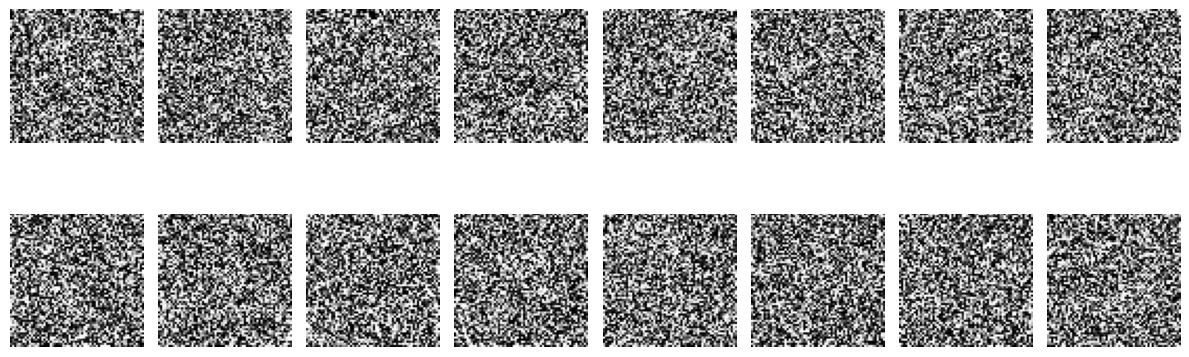

312/312 [==============================] - 581s 1s/step - loss: 0.0712
Epoch 2/20
312/312 [==============================] - ETA: 0s - loss: 0.0031

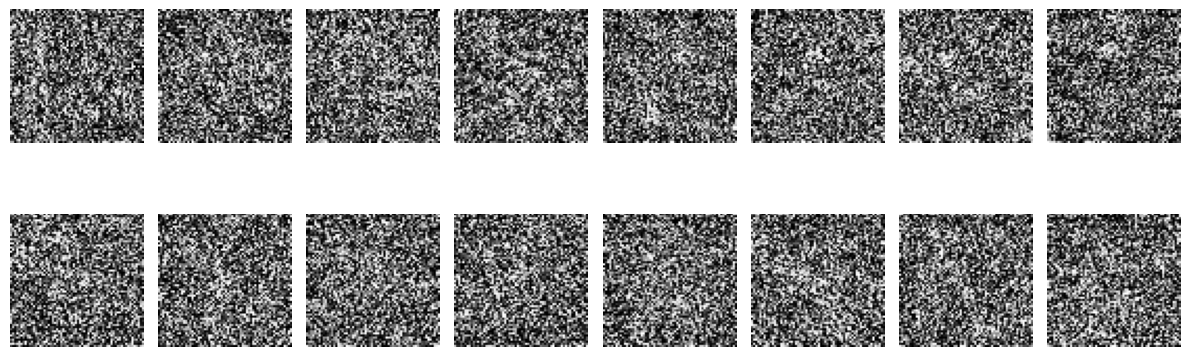

312/312 [==============================] - 443s 1s/step - loss: 0.0031
Epoch 3/20
312/312 [==============================] - ETA: 0s - loss: 0.0026

312/312 [==============================] - 443s 1s/step - loss: 0.0026
Epoch 4/20
312/312 [==============================] - ETA: 0s - loss: 0.0024

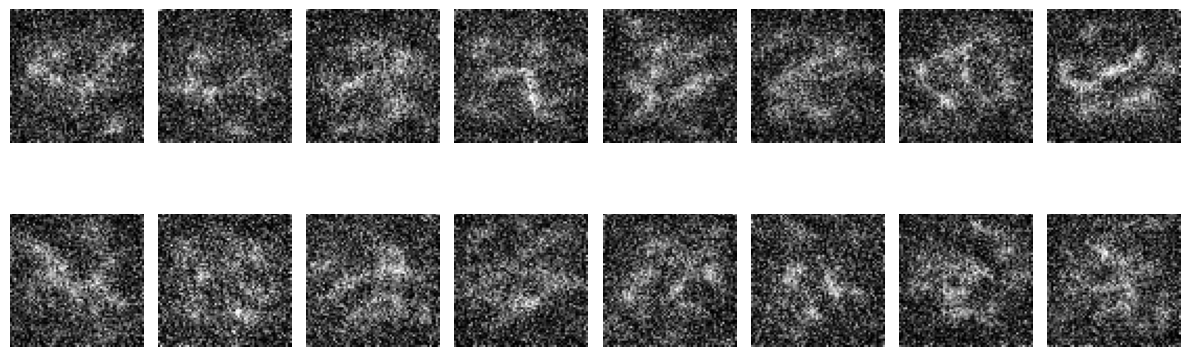

312/312 [==============================] - 443s 1s/step - loss: 0.0024
Epoch 5/20
312/312 [==============================] - ETA: 0s - loss: 0.0022

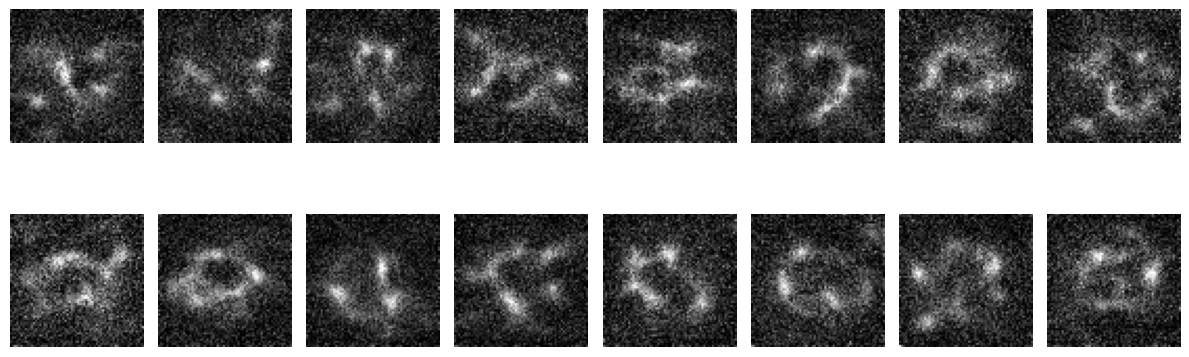

312/312 [==============================] - 449s 1s/step - loss: 0.0022
Epoch 6/20
312/312 [==============================] - ETA: 0s - loss: 0.0022

312/312 [==============================] - 451s 1s/step - loss: 0.0022
Epoch 7/20
312/312 [==============================] - ETA: 0s - loss: 0.0019

312/312 [==============================] - 456s 1s/step - loss: 0.0019
Epoch 8/20
312/312 [==============================] - ETA: 0s - loss: 0.0019

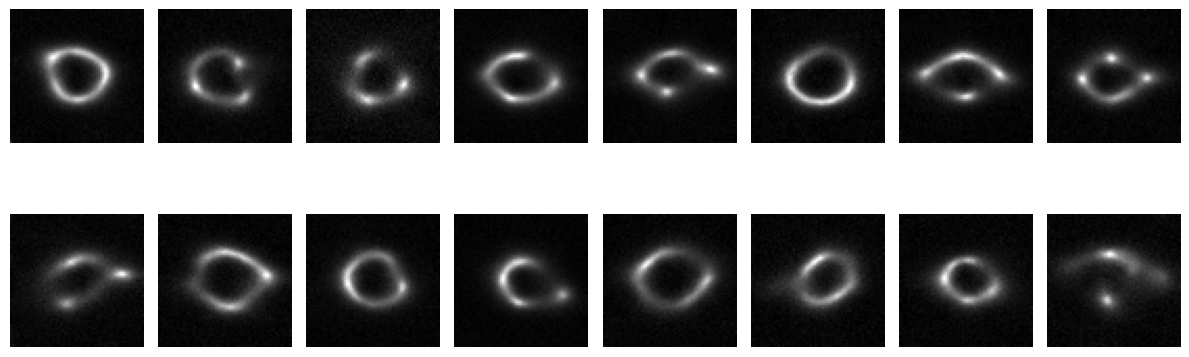

312/312 [==============================] - 458s 1s/step - loss: 0.0019
Epoch 9/20
312/312 [==============================] - ETA: 0s - loss: 0.0018

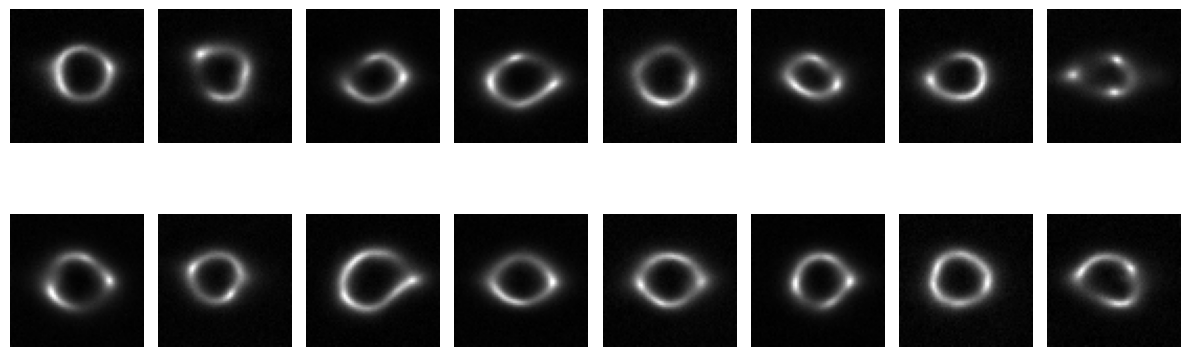

312/312 [==============================] - 453s 1s/step - loss: 0.0018
Epoch 10/20
312/312 [==============================] - ETA: 0s - loss: 0.0018

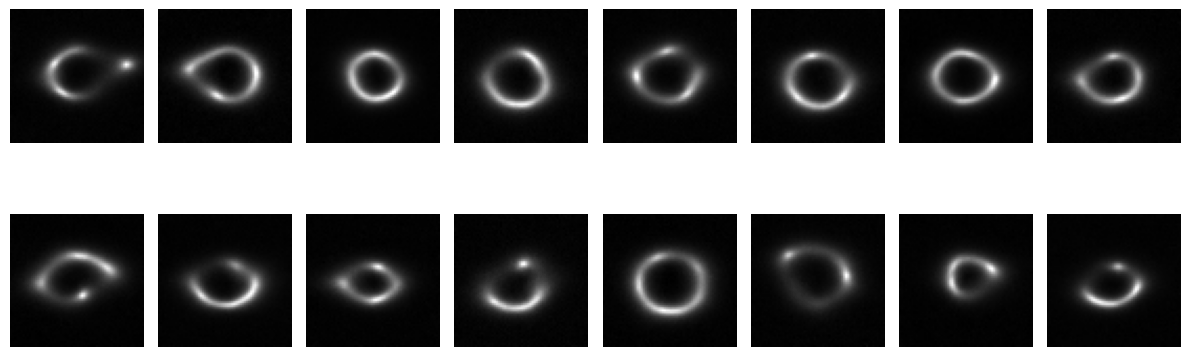

312/312 [==============================] - 448s 1s/step - loss: 0.0018
Epoch 11/20
312/312 [==============================] - ETA: 0s - loss: 0.0017

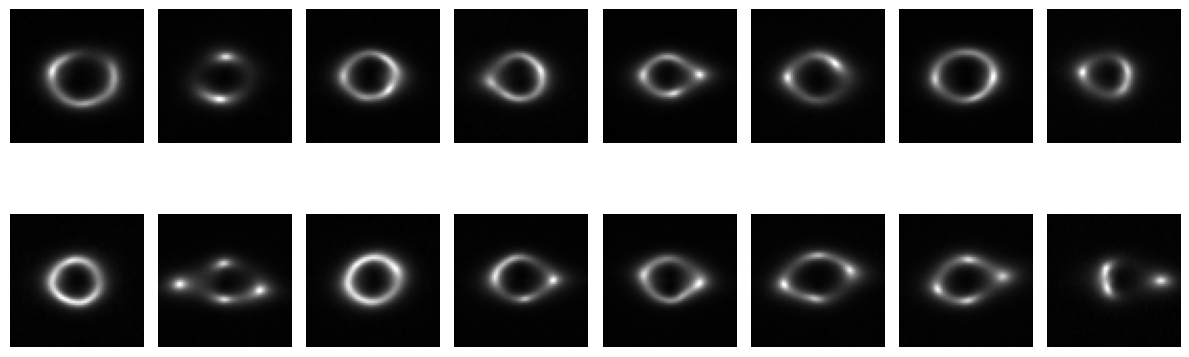

312/312 [==============================] - 451s 1s/step - loss: 0.0017
Epoch 12/20
312/312 [==============================] - ETA: 0s - loss: 0.0016

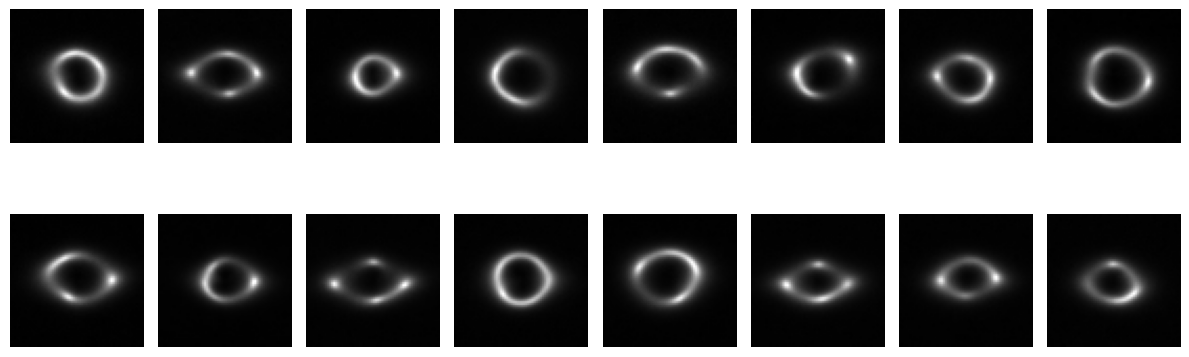

312/312 [==============================] - 450s 1s/step - loss: 0.0016
Epoch 13/20
312/312 [==============================] - ETA: 0s - loss: 0.0017

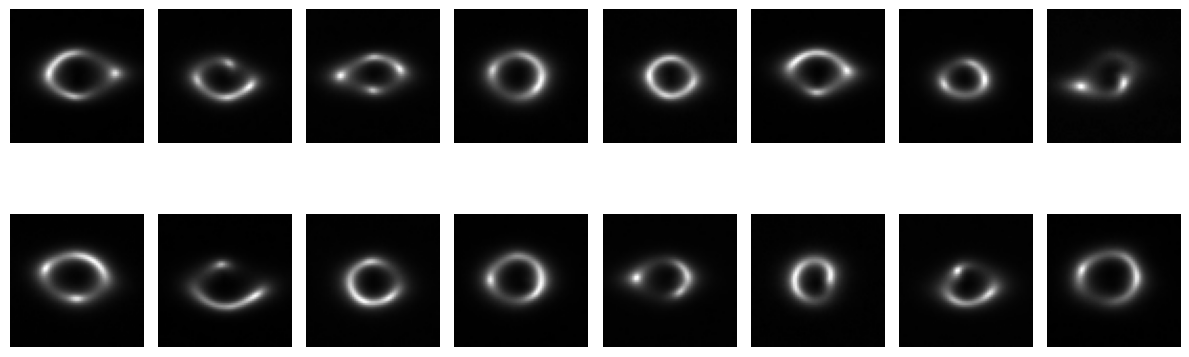

312/312 [==============================] - 449s 1s/step - loss: 0.0017
Epoch 14/20
312/312 [==============================] - ETA: 0s - loss: 0.0016

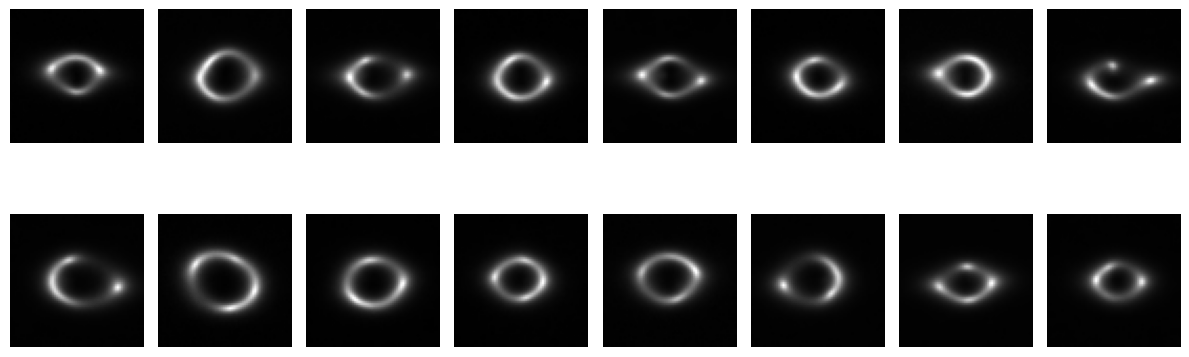

312/312 [==============================] - 450s 1s/step - loss: 0.0016
Epoch 15/20
312/312 [==============================] - ETA: 0s - loss: 0.0016

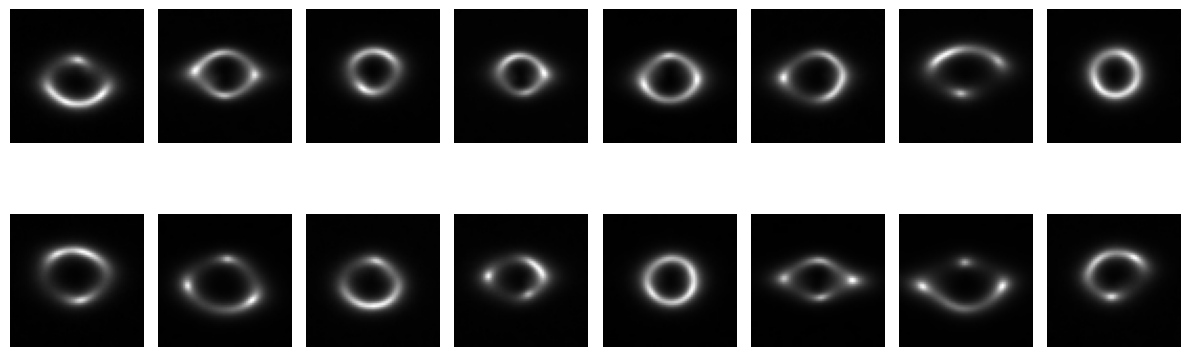

312/312 [==============================] - 456s 1s/step - loss: 0.0016
Epoch 16/20
312/312 [==============================] - ETA: 0s - loss: 0.0015

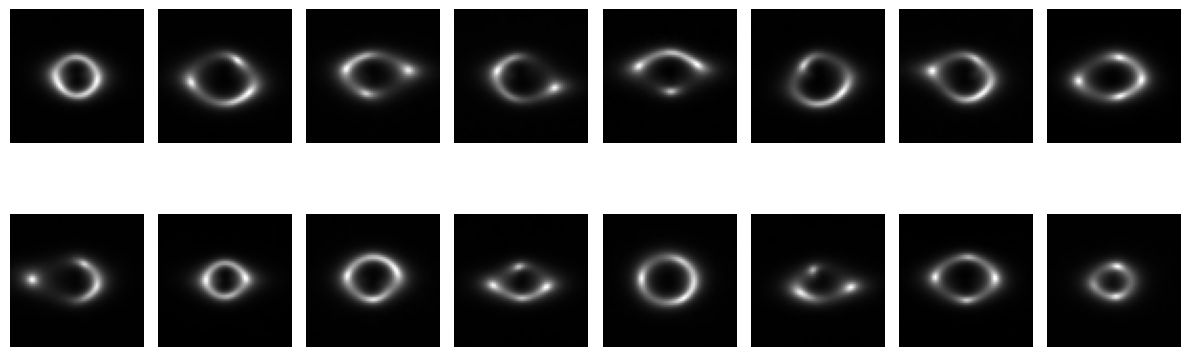

312/312 [==============================] - 460s 1s/step - loss: 0.0015
Epoch 17/20
312/312 [==============================] - ETA: 0s - loss: 0.0015

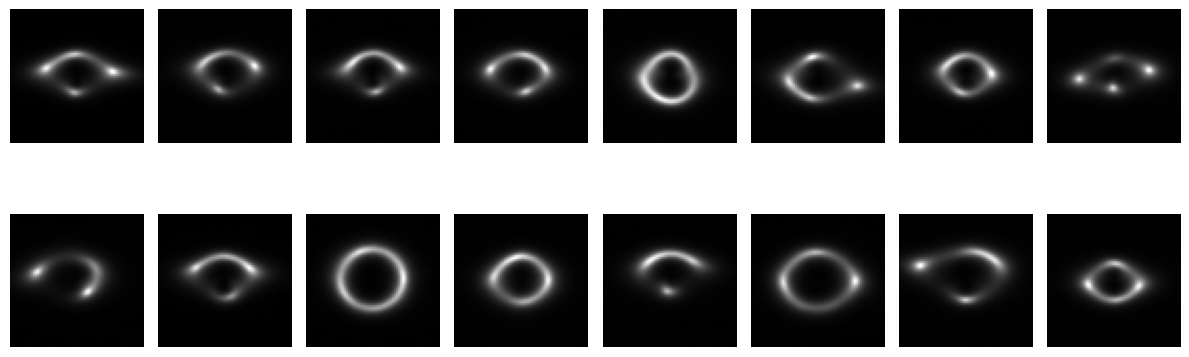

312/312 [==============================] - 448s 1s/step - loss: 0.0015
Epoch 18/20
312/312 [==============================] - ETA: 0s - loss: 0.0015

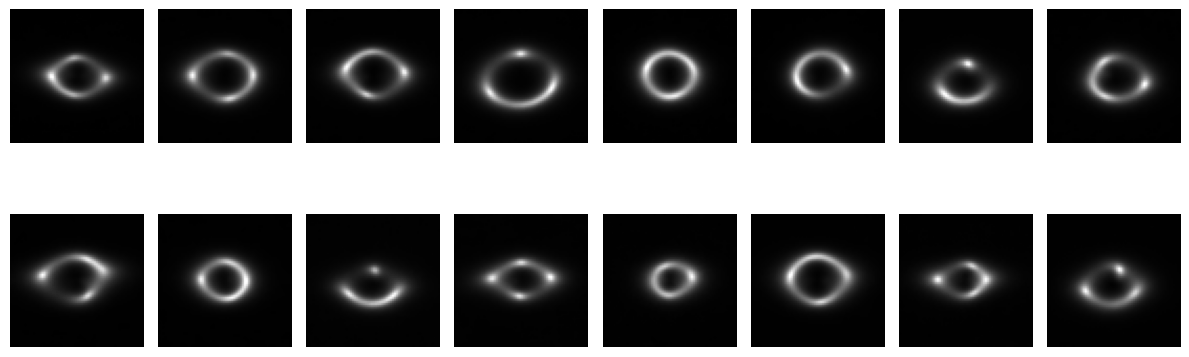

312/312 [==============================] - 450s 1s/step - loss: 0.0015
Epoch 19/20
312/312 [==============================] - ETA: 0s - loss: 0.0015

312/312 [==============================] - 449s 1s/step - loss: 0.0015
Epoch 20/20
312/312 [==============================] - ETA: 0s - loss: 0.0015

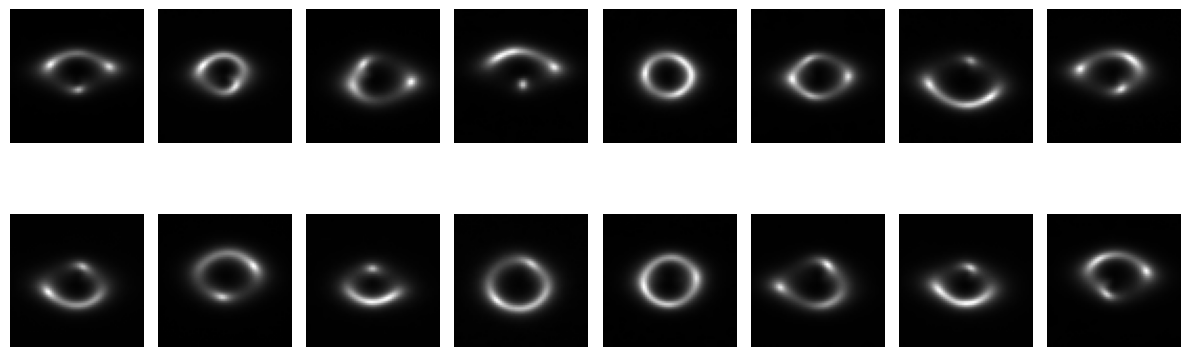

312/312 [==============================] - 453s 1s/step - loss: 0.0015


In [ ]:
class DiffusionModel(keras.Model):
    """Diffusion model for training and generating images."""

    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        """
        Initialize the DiffusionModel.

        Args:
            network (keras.Model): The main U-Net network.
            ema_network (keras.Model): Exponential Moving Average (EMA) U-Net network.
            timesteps (int): Number of diffusion timesteps.
            gdf_util (GaussianDiffusion): Gaussian diffusion utility.
            ema (float): Exponential Moving Average decay rate.
        """
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, images):
        """
        Perform a single training step.

        Args:
            images (Tensor): Batch of input images.

        Returns:
            dict: Dictionary containing the loss value.
        """
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Update the EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):
        """
        Generate images using the trained diffusion model.

        Args:
            num_images (int): Number of images to generate.

        Returns:
            Tensor: Generated images.
        """
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )

        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )

        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        """
        Utility to plot images using the diffusion model during training.

        Args:
            epoch (int): Current epoch number.
            logs (dict): Log data from the training process.
            num_rows (int): Number of rows in the plot grid.
            num_cols (int): Number of columns in the plot grid.
            figsize (tuple): Figure size for the plot.
        """
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 255.0, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image[:, :, 0], cmap='gray')
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(
                    image[:, :, 0], cmap='gray'
                )
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()


# Build the U-Net model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)

# Create an EMA U-Net model with the same architecture
ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)

# Initialize the EMA weights with the U-Net weights
ema_network.set_weights(network.get_weights())

# Instantiate the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Instantiate the diffusion model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the diffusion model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
)

# Train the diffusion model
model.fit(
    train_ds,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images)],
)

## Testing the diffusion model

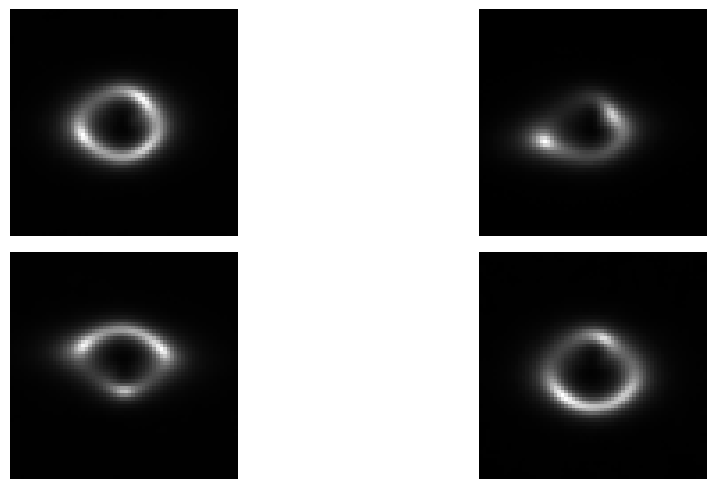

In [ ]:
# Generating and ploting some sample images
model.plot_images(num_rows=2, num_cols=2)